# 05-1. 검증 세트를 나누고 전처리 과정을 배웁니다

## 테스트 세트로 모델을 튜닝합니다

### 로지스틱 회귀로 모델 훈련하고 평가하기

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify = y,test_size = 0.2, random_state = 42)

:loss 매개변수의 값을 log로 지정하여 로지스틱 손실 함수를 손실 함수로 지정해보자

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

: 위에서 확인할 수 있듯이 테스트 세트에서 정확도는 약 83%이다.   
loss와 같은 매개변수의 값은 가중치나 절편처럼 알아서 학습되는 것이 아니다. 즉 사용자가 직접 선택해야 되는데, 이런 값을 특별히 하이퍼파라미터(hyperparameter)라고 부른다. loss의 값을 바꾸면 성능이 정말 좋아지는지 확인해보자

### 서포트 벡터 머신으로 모델 훈련하고 평가하기
: loss 매개변수를 Log에서 hinge로 바꾸면 선형 서포트 벡터 머신 문제를 푸는 모델이 만들어진다. 여기서 SVM이란 '훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업'정도로 이해하고 넘어가자  

아래의 결과에서 알 수 있듯이 로지스틱 회귀로 만들 모델의 성능보다 더 좋아졌다. 성능이 만족스럽지 않을 경우 이렇게 loss 매개변수에 다른 값을 적용했듯이 클래스의 다른 매개변수들을 바꿔보면 된다. 그리고 이러한 작업을 '모델을 튜닝한다'라고 한다. 그런데 이 모델은 실전에서는 좋은 성능을 내지 못할 확률이 높다. 왜 그럴까? 지금부터 그 이유에 대해 알아보자.

In [ ]:
sgd = SGDClassifier(loss = 'hinge', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

## 검증 세트를 준비합니다

1. 데이터 세트 준비하기


In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify = y,test_size = 0.2, random_state = 42)

2. 검증 세트 분할하기  
: 앞에서 훈련, 검증, 테스트 세트는 6:2:2 정도로 분할한다고 했는데, 실제 분할 작업은 처음부터 6:2:2 비율로 나누는 것이 아닌 전체 데이터 세트를 8:2로 나누어 훈련 세트와 테스트 세트를 만들고 다시 훈련 세트를 8:2로 나누어 훈련 세트와 검증 세트를 만든다  
아래에서 455개의 훈련 세트가 8:2 비율로 나누어져 훈련 세트(x_train)는 364개, 검증 세트는 (x_val) 91개가 된 것을 확인할 수 있다

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,stratify = y_train_all, test_size = 0.2, random_state = 42)
print(len(x_train),len(x_val))

364 91


3. 검증 세트 사용해 모델 평가하기
:  검증 세트로 모델을 평가해보자. 결과를 보니 앞의 실습에서 얻은 평가 점수보다 조금 낮아진 것을 확인 할 수 있는데 그 이유는 훈련 세트의 크기가 줄어들었기 때문이다

In [7]:
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

## 스케일을 조정하지 않고 모델을 훈련해볼까요?
1. 훈련 데이터 준비하고 스케일 비교하기  
: 그래프에서 확인할 수 있듯이 두 특성의 스케일을 차이가 크다. mean perimeter는 주로 100~200 사이에 값들이 위치한 반면에 mean area는 200~2000사이에 값들이 집중되어 있다. 이렇게 스케일이 다른 두 특성에 경사 하강법 알고리즘을 적용하면 가중치가 어떻게 변할까?

In [9]:
import matplotlib.pyplot as plt
import numpy as np

['mean perimeter' 'mean area']


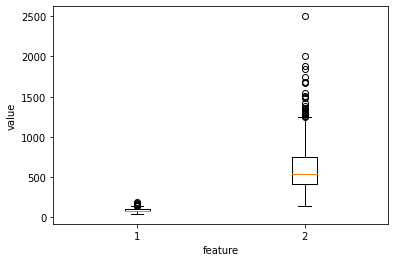

In [10]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

2. 가중치를 기록할 변수와 학습률 파라미터 추가하기  
: 클래스에 인스턴스 변수를 추가하여 에포크마다 가중치의 값을 저장하여 가중치의 변화를 관찰할 때 사용해보자. 또 학습률이라는 개념도 도입해보자. 먼저 init()메서드에서 인스턴스 변수 w_history를 만들고 학습률 파라미터 learning_rate를 추가하자.  

- learnig_rate: 하이퍼파라미터이며 변수 이름 그대로 학습률을 의미하는데, 이 값으로 가중치의 업데이트 양을 조절할 수 있다. 
- 가중치를 큰 폭으로 업데이트하여 손실 함수가 최소가 될 수 있는 지점인 전역 최소값을 지나쳐 버리게 되면 최적의 해를 구할 수 없으므로, 전역 최솟값을 놓치지 않도록 가중치의 업데이트 양을 조절할 필요가 있다. 

3. 가중치 기록하고 업데이트 양 조절하기
: fit()메서드에 가중치가 바뀔 때마다 w_history 리스트에 가중치를 기록하겠다. 

In [11]:
class SingleLayer:
  def __init__(self, learning_rate = 0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self,x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self,z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs = 100):
    self.w = np.ones(x.shape[1]) # 가중치를 초기화합니다
    self.b = 0                   # 절편을 초기화합니다
    self.w_history.append(self.w.copy()) #가중치를 기록합니다
    np.random.seed(42)           # 무작위로 시드를 지정합니다
    for i in range(epochs):      # epoches만큼 반복합니다
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다
      for i in indexes:            # 모든 샘플에 대해 반복합니다
        z = self.forpass(x[i])     # 정방향 계산
        a = self.activation(z)     # 활성화 함수 적용
        err = -(y[i] - a)          # 오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 역방향 계산
        self.w -= self.lr * w_grad # 가중치 업데이트(학습률 적용)
        self.b -= b_grad           # 절편 업데이트
        # 가중치를 기록합니다
        self.w_history.append(self.w.copy( ))
        a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) 
      self.losses.append(loss/len(y))  # 에포크마다 평균 손실을 저장합니다

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 선형 함수 적용
    return np.array(z) > 0               # 계단 함수 적용

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

4. 모델 훈련하고 평가하기  
: 이제 스케일을 조정하지 않은 훈련 세트를 사용하여 모델을 훈련하고 모델의 성능 점수를 확인해보자.

In [13]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


0.9120879120879121

5. layer1 객체의 인스턴스 변수 w_history에는 100번의 에포크 동안 변경된 가중치가 모두 기록되어 있다. 이때 세 번째, 네 번째 요소 (w[2],w[3])는 각각 mean perimeter, mean area특성에 대한 가중치이다. 이 요소로 그래프를 그려보자. 또 최종으로 결정된 가중치는 점으로 표시해보자  
그래프를 보면 mean perimeter에 비해 mean area의 스케일이 크므로 w3 값이 학습 과정에서 큰 폭으로 흔들리며 변화하고 있다. 이 그래프의 현상을 'w3에 대한 그레디언트가 크기 때문에 w3축을 따라 가중치가 크게 요동치고 있다'라고 말한다. 즉 가중치의 최적값에 도달하는 동안 w3의 값이 크게 요동치므로 모델이 불안정하게 수렴한다는 것을 알 수 있다. 이런 현상을 어떻게 줄일 수 있을까? 바로 스케일을 조정하면 된다.

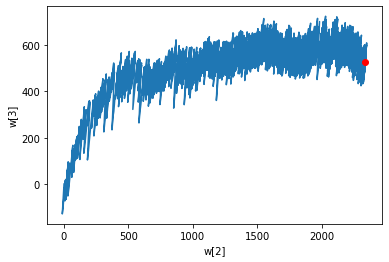

In [14]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

## 스케일을 조정해 모델을 훈련합니다
1. 넘파이로 표준화 구현하기  
: 넘파이의 mean(), std() 함수를 사용하여 평균과 표준편차를 계산하면 표준화를 쉽게 구현할 수 있다. 표준화를 구현한 다음에는 특성별로 스케일을 조정한다. mean(), std() 함수의 축 매개변수를 0으로 지정하면 2차원 배열의 열을 기준으로 통계치를 계산하여 하나의 행 벡터로 반환해 준다. 그런 다음 훈련 세트 x_train 에서 평균을 빼고 표준 편차로 나누면 된다.

In [15]:
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)
x_train_scaled = (x_train - train_mean) / train_std

2. 모델 훈련하기  
: 이제 스케일을 조정한 데이터 세트로 단일층 신경망을 다시 훈련시키고 가중치를 그래프로 그려보자  
이전 그래프와는 확실히 다른 결과를 보여줌을 알 수 있다. w2,w3의 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치가 이동되었다. 또한 두 특성의 스케일을 비슷하게 맞추었으므로 최적값에 빠르게 근접하고 있음을 알 수 있다. 이처럼 경사 하강법에는 서로 다른 특성의 스케일을 맞추는 것이 아주 중요하다. 이제 검증 세트를 통해 이 모델을 평가해보자


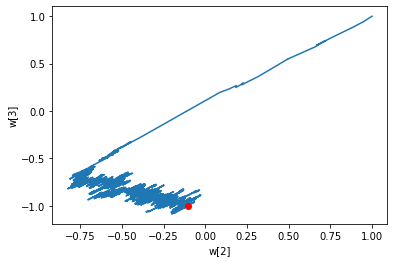

In [17]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

3. 모델 성능 평가하기

In [18]:
layer2.score(x_val, y_val)

0.37362637362637363

4. 성능이 매우 좋지 않다. 그 이유는 훈련 세트와 검증 세트의 스케일이 비슷할 것이라고 이 모델이 기대하는 반면에 검증 세트의 스케일을 바꾸지 않았기 때문이다. 검증 세트로 표준화 전처리를 적용해 보자.

In [19]:
val_mean = np.mean(x_val, axis = 0)
val_std = np.std(x_val, axis = 0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

## 스케일을 조정한 다음에 실수하기 쉬운 함정을 알아봅니다
: 함정이란 '훈련 세트와 검증 세트가 다른 비율로 스케일이 조정된 경우'를 말한다. 이해를 돕기 위해 원본 훈련 세트와 검증 세트, 전처리된 훈련 세트와 검증 세트에서 데이터를 50개씩 뽑아 산점도를 그린 다음 산점도를 비교해 보며 이 함정에 대해 설명해보겠다.

1. 원본 훈련 세트와 검증 세트로 산점도 그리기  
: 파란 점이 훈련 세트, 빨간 점이 검증 세트이다.

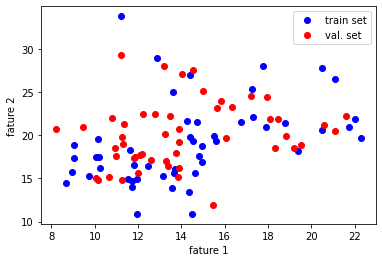

In [20]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50,0],x_val[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

2. 전처리한 훈련 세트와 검증 세트로 산점도 그리기  
: 위의 선점도와 아래의 선점도를 비교해보면 미세하지만 훈련 세트와 검증 세트가 각각 다른 비율로 변환되었음을 알 수 있다. 즉, 원본 훈련 세트와 검증 세트의 점과 점 사이의 거리가 변환된 이후에 그대로 유지되지 않았다. 데이터를 제대로 전처리했다면 훈련 세트와 검증 세트의 거리가 그대로 유지되어야 한다. 점과 점 사이의 거리가 달라진 이유는 훈련 세트와 검증 세트를 각각 다른 비율로 전처리 했기 때문이다.

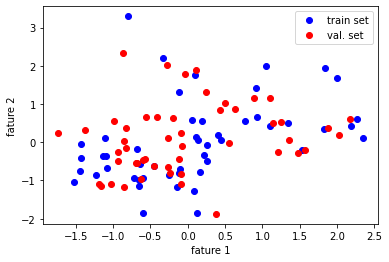

In [21]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50,0],x_val_scaled[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

3. 올바르게 검증 세트 전처리하기
: 검증 세트의 스케일이 훈련 세트의 스케일과 다른 비율로 조정되면 모델에 적용된 알고리즘들이 검증 세트의 샘플 데이터를 잘못 인식하기 때문에 검증 세트를 훈련 세트와 같은 비율로 전처리 해야 한다. 이는 훈련 세트의 평균, 표준 편차를 사용하여 검증 세트를 변환하면 된다.

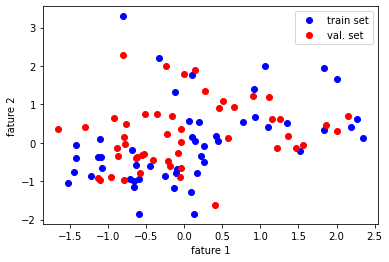

In [22]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

4. 모델 평가하기

In [23]:
layer2.score(x_val_scaled, y_val)

0.967032967032967